<a href="https://colab.research.google.com/github/killercookiee/DeepM/blob/main/DeepM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/killercookiee/DeepM

Cloning into 'DeepM'...
remote: Enumerating objects: 1091, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1091 (delta 12), reused 12 (delta 6), pack-reused 1062 (from 1)
Receiving objects: 100% (1091/1091), 314.78 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (301/301), done.
Updating files: 100% (833/833), done.


Understanding the File format

Neuroimaging Informatics Technology Initiative
NIfTI is designed to handle 3D (volume) and 4D (time-series) data, which is common in brain imaging, especially for functional MRI (fMRI) studies
NIfTI files can also be stored in a compressed .nii.gz format to save disk space

4 D --> Height + Width + Depth + Time

We are working with pairs of files. Example
1. Say MRI scan of heart
2. Corresponding segmentation mask file -> i.e. a label that marks different part of the image, like heart chambers, valves, etc

Possibly

patient001_4d.nii.gz -> 4D file (Sequence of 3d images over time), not used for segmentation
patient001_frame01.nii.gz -> A single 2D slice of the 3D MRI data. Image file used for traning the model
patient001_frame01_gt.nii.gz -> It contains labels marking the regions of interest in the image

# Imports

In [2]:
%pip install opencv-python --quiet
%pip install scikit-image --quiet

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
import plotly.graph_objects as go  # Graph Objects module comprises visuals like Heatmaps, Figures, etc
import torch.nn.functional as F


# Training and Testing Data List

In [4]:
def select_new_training_data(dataset_dir):
    data_anomolies = ['038', '085', '057', '089', '100']

    training_data_list = {}
    for k in ['training']:

        subset_dir = os.path.join(dataset_dir, k)
        training_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] == 't' and file[-21:-18] not in data_anomolies:

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        training_data_list[k] += [[image_name, segt_name, patient]]

    return training_data_list



def select_new_testing_data(dataset_dir):
    testing_data_list = {}

    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)
        testing_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] != 'd' and file[-8] != 'I':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        testing_data_list[k] += [[image_name, segt_name, patient]]

    return testing_data_list



training_data_list = select_new_training_data("./DeepM/MIS-working-database")
testing_data_list = select_new_testing_data("./DeepM/MIS-working-database")

In [5]:
# training_data_list

# Visualising Original Ground Truth Segmentation


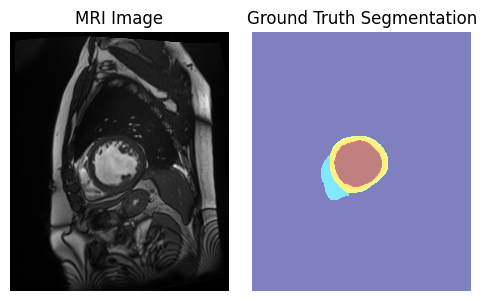

In [7]:
def visualize_ground_truth(training_data_list, index=0):
    # Get the image and segmentation files for a particular index
    image_file = training_data_list['training'][index][0]
    segt_file = training_data_list['training'][index][1]

    # Load the MRI image and its ground truth label
    img = nib.load(image_file)
    segt = nib.load(segt_file)

    img_data = img.get_fdata()
    segt_data = segt.get_fdata()

    # Select a slice from the image (you can change this depending on the 3D data)
    slice_idx = img_data.shape[2] // 2  # Choose the middle slice for visualization
    img_slice = img_data[:, :, slice_idx]
    segt_slice = segt_data[:, :, slice_idx]

    # Plot the MRI image and its corresponding ground truth label
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))

    # Display the MRI image
    axes[0].imshow(img_slice.T, cmap='gray')
    axes[0].set_title('MRI Image')
    axes[0].axis('off')

    # Display the ground truth label (segmentation mask)
    axes[1].imshow(segt_slice.T, cmap='jet', alpha=0.5)
    axes[1].set_title('Ground Truth Segmentation')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # segt_data

# Example: Visualize the first image and its ground truth
visualize_ground_truth(training_data_list, index=0)

In [8]:
def check_ground_truth_values(training_data_list, index=0):
    # Get the segmentation file for a particular index
    segt_file = training_data_list['training'][index][1]

    # Load the segmentation (ground truth) file
    segt = nib.load(segt_file)
    segt_data = segt.get_fdata()

    # Print the unique pixel values in the segmentation mask
    unique_values = np.unique(segt_data)
    print(f"Unique pixel values in ground truth label: {unique_values}")

    return unique_values

# Example: Check the pixel values of the ground truth
unique_values = check_ground_truth_values(training_data_list, index=0)

Unique pixel values in ground truth label: [0. 1. 2. 3.]


In [11]:
type(training_data_list)

dict

# Converting NII.GZ to slices of .tif format


In [12]:
import os
import nibabel as nib
import numpy as np
from PIL import Image

# Function to split filenames (unchanged)
def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext

# Function to process and save 3D .nii.gz as 2D .tif slices
def nii_to_tif(input_path, output_dir, axis=2, pct_range=(0.2, 0.8)):
    _, base, ext = split_filename(input_path)
    img = nib.load(input_path).get_fdata().astype(np.float32).squeeze()

    if img.ndim != 3:
        print(f"Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.")
        return

    start = int(pct_range[0] * img.shape[axis])
    end = int(pct_range[1] * img.shape[axis])

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over slices and save them as TIFF images
    for i in range(start, end):
        if axis == 0:
            slice_img = img[i, :, :]
        elif axis == 1:
            slice_img = img[:, i, :]
        else:
            slice_img = img[:, :, i]

        # Normalize to uint8 for better compatibility with visualization tools
        slice_img = np.uint8(np.clip(slice_img, 0, 255))  # Clip to valid uint8 range

        # Convert the slice to an image and save it as a .tif file
        slice_tif = Image.fromarray(slice_img, mode='L')  # 'L' mode for grayscale
        slice_tif.save(os.path.join(output_dir, f"{base}_{i:04}.tif"))

# Process training data
for entry in training_data_list['training']:
    img_path, gt_path, patient_id = entry
    nii_to_tif(img_path, f"./output/training/images/{patient_id}")
    nii_to_tif(gt_path, f"./output/training/labels/{patient_id}")

# Process testing data
for entry in testing_data_list['testing']:
    img_path, gt_path, patient_id = entry
    nii_to_tif(img_path, f"./output/testing/images/{patient_id}")
    nii_to_tif(gt_path, f"./output/testing/labels/{patient_id}")


In [13]:
# pip install imageio
!pip install pillow
import tensorflow as tf

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
# import shutil

# # Source folder in Colab
# source_folder = "./output"

# # Destination folder in Google Drive
# destination_folder = "/content/drive/My Drive/ColabBackup/output"

# # Copy folder to Google Drive
# shutil.copytree(source_folder, destination_folder)
# print(f"Folder copied to {destination_folder}")


##### Initially attempted a dummy UNET architecture but found it computationally heavy . I switched to a simpler feedforward CNN, which provided faster training, required fewer resources, and was sufficient for this task

In [17]:
import tensorflow as tf
import os
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar



np.random.seed(678)
tf.random.set_seed(5678)

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(s): return tf.cast(tf.greater(s,0), dtype=tf.float32)
def tf_softmax(x): return tf.nn.softmax(x)
def np_sigmoid(x): return 1 / (1 + np.exp(-x))

# # --- Custom layers ---
# class ConLayerLeft(tf.keras.layers.Layer):
#     def __init__(self, ker, in_c, out_c):
#         super(ConLayerLeft, self).__init__()
#         # Corrected: define weight with shape as a tuple
#         self.w = self.add_weight(
#             name='conv_kernel',
#             shape=(ker, ker, in_c, out_c),  # shape as a tuple
#             initializer=tf.random_normal_initializer(stddev=0.05)
#         )
#         self.b = self.add_weight(
#             name='bias',
#             shape=(out_c,),  # Bias shape is (out_c,) for each output channel
#             initializer=tf.zeros_initializer()
#         )

#     def call(self, input, stride=1, dilate=1):
#         # Use the weight in a convolution operation
#         x = tf.nn.conv2d(input, self.w, strides=[1, stride, stride, 1], padding="SAME")
#         x = x + self.b  # Add bias
#         return x

# --- Custom layers ---
class ConLayerLeft(tf.keras.layers.Layer):
    def __init__(self, kernel_size, in_channels, out_channels):
        super(ConLayerLeft, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x




In [18]:
from skimage.transform import resize
import imageio

In [19]:
# --- get data ---
data_location = "./output/training/images/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)): ## checks all subdirectories
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            train_data.append(os.path.join(dirName,filename))

data_location = "./output/training/labels/"
train_data_gt = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            train_data_gt.append(os.path.join(dirName,filename))

num_images = len(train_data)
num_labels = len(train_data_gt)

train_images = np.zeros(shape=(num_images, 256, 256, 1))
train_labels = np.zeros(shape=(num_labels, 256, 256, 1))

# for file_index in range(len(train_data)):
#     train_images[file_index,:,:]   = np.expand_dims(imresize(imread(train_data[file_index],mode='F',flatten=True),(256,256)),axis=2)
#     train_labels[file_index,:,:]   = np.expand_dims(imresize(imread(train_data_gt[file_index],mode='F',flatten=True),(256,256)),axis=2)

for file_index in range(len(train_data)):
#     train_images[file_index,:,:]   = np.expand_dims(imresize(imread(train_data[file_index],mode='F',flatten=True),(256,256)),axis=2)
#     train_labels[file_index,:,:]   = np.expand_dims(imresize(imread(train_data_gt[file_index],mode='F',flatten=True),(256,256)),axis=2)
    # Read the image without the 'mode' argument
      img = imageio.imread(train_data[file_index])

      # Convert the image to float32 if it's not already in the desired format
      img = img.astype(np.float32)

      # Resize the image and expand dimensions
      train_images[file_index, :, :] = np.expand_dims(
          resize(img, (256, 256), mode='reflect'), axis=2
      )

      # Read the corresponding label
      label = imageio.imread(train_data_gt[file_index])

      # Convert label to float32 if needed
      label = label.astype(np.float32)

      # Resize the label and expand dimensions
      train_labels[file_index, :, :] = np.expand_dims(
          resize(label, (256, 256), mode='reflect'), axis=2
      )

train_images = (train_images - train_images.min()) / (train_images.max() - train_images.min())
train_labels = (train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())

<ipython-input-19-5ee0a63518e5>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(train_data[file_index])
<ipython-input-19-5ee0a63518e5>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(train_data_gt[file_index])


In [20]:

unique_values = np.unique(train_labels)

# Print unique values
print("Unique values in the 4D array:", unique_values)

Unique values in the 4D array: [0.00000000e+00 8.13802083e-05 1.22070312e-04 ... 9.99755859e-01
 9.99918620e-01 1.00000000e+00]


In [72]:
# --- Hyperparameters ---
num_epoch = 100
init_lr = 0.0001
batch_size = 10

# --- Make Layer Objects ---
# Left layers
l1_1, l1_2, l1_3 = ConLayerLeft(3, 1, 3), ConLayerLeft(3, 3, 3), ConLayerLeft(3, 3, 3)
l2_1, l2_2, l2_3 = ConLayerLeft(3, 3, 6), ConLayerLeft(3, 6, 6), ConLayerLeft(3, 6, 6)
l3_1, l3_2, l3_3 = ConLayerLeft(3, 6, 12), ConLayerLeft(3, 12, 12), ConLayerLeft(3, 12, 12)
l4_1, l4_2, l4_3 = ConLayerLeft(3, 12, 24), ConLayerLeft(3, 24, 24), ConLayerLeft(3, 24, 24)
l5_1, l5_2, l5_3 = ConLayerLeft(3, 24, 48), ConLayerLeft(3, 48, 48), ConLayerLeft(3, 48, 24)

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers
        self.l1_1, self.l1_2, self.l1_3 = l1_1, l1_2, l1_3
        self.l2_1, self.l2_2, self.l2_3 = l2_1, l2_2, l2_3
        self.l3_1, self.l3_2, self.l3_3 = l3_1, l3_2, l3_3
        self.l4_1, self.l4_2, self.l4_3 = l4_1, l4_2, l4_3
        self.l5_1, self.l5_2, self.l5_3 = l5_1, l5_2, l5_3

        # Add upsampling layers to restore the original size
        self.upsample_4 = tf.keras.layers.Conv2DTranspose(24, kernel_size=3, strides=2, padding="same")
        self.upsample_3 = tf.keras.layers.Conv2DTranspose(12, kernel_size=3, strides=2, padding="same")
        self.upsample_2 = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, strides=2, padding="same")
        self.upsample_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same")

        self.final_conv = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')

    def call(self, x):
        # Forward pass through layers
        layer1_1 = self.l1_1(x)
        layer1_2 = self.l1_2(layer1_1)
        layer1_3 = self.l1_3(layer1_2)

        layer2_Input = tf.nn.max_pool(layer1_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer2_1 = self.l2_1(layer2_Input)
        layer2_2 = self.l2_2(layer2_1)
        layer2_3 = self.l2_3(layer2_2)

        layer3_Input = tf.nn.max_pool(layer2_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer3_1 = self.l3_1(layer3_Input)
        layer3_2 = self.l3_2(layer3_1)
        layer3_3 = self.l3_3(layer3_2)

        layer4_Input = tf.nn.max_pool(layer3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer4_1 = self.l4_1(layer4_Input)
        layer4_2 = self.l4_2(layer4_1)
        layer4_3 = self.l4_3(layer4_2)

        layer5_Input = tf.nn.max_pool(layer4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer5_1 = self.l5_1(layer5_Input)
        layer5_2 = self.l5_2(layer5_1)
        layer5_3 = self.l5_3(layer5_2)

        # Upsample layers to match the input size
        up4 = self.upsample_4(layer5_3)
        up3 = self.upsample_3(up4)
        up2 = self.upsample_2(up3)
        up1 = self.upsample_1(up2)

        # Final convolution to get the output with the same shape as train_labels
        output = self.final_conv(up1)

        return output







Justification:

Dice Loss: Ideal for segmentation tasks as it focuses on overlap, balancing class imbalance by emphasizing regions with smaller overlap between predicted and ground truth masks.
Adam Optimizer: Adaptive learning rate and momentum make it efficient for sparse gradients and non-stationary objectives, ensuring smooth convergence during training.

In [73]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

In [74]:
from tqdm import tqdm

# --- Instantiate and compile model ---
model = MyModel()

# Compile model with optimizer, loss, and metrics
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
#               loss=tf.keras.losses.MeanSquaredError(),
#               metrics=['accuracy'])

model.compile(optimizer = optimizer,
              loss=dice_loss)

# Model training with tqdm progress bar
for epoch in tqdm(range(num_epoch), desc="Training Epochs", unit="epoch"):
    # Use the training data as is, no need to resize train_labels
    model.fit(train_images, train_labels, epochs=1, batch_size=batch_size, verbose=1)


Training Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]

111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.9424


Training Epochs:   1%|          | 1/100 [00:30<50:17, 30.48s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9356


Training Epochs:   2%|▏         | 2/100 [00:34<24:31, 15.02s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7200


Training Epochs:   3%|▎         | 3/100 [00:38<16:08,  9.98s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5493


Training Epochs:   4%|▍         | 4/100 [00:42<11:51,  7.41s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4707


Training Epochs:   5%|▌         | 5/100 [00:46<10:02,  6.34s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4479


Training Epochs:   6%|▌         | 6/100 [00:49<08:19,  5.31s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3956


Training Epochs:   7%|▋         | 7/100 [00:53<07:34,  4.89s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3836


Training Epochs:   8%|▊         | 8/100 [00:57<06:57,  4.54s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3711


Training Epochs:   9%|▉         | 9/100 [01:01<06:37,  4.37s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3660


Training Epochs:  10%|█         | 10/100 [01:05<06:04,  4.04s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3556


Training Epochs:  11%|█         | 11/100 [01:08<05:40,  3.82s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3500


Training Epochs:  12%|█▏        | 12/100 [01:12<05:49,  3.97s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3434


Training Epochs:  13%|█▎        | 13/100 [01:16<05:44,  3.96s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3343


Training Epochs:  14%|█▍        | 14/100 [01:19<05:23,  3.76s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3295


Training Epochs:  15%|█▌        | 15/100 [01:24<05:34,  3.94s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3272


Training Epochs:  16%|█▌        | 16/100 [01:27<05:11,  3.71s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3270


Training Epochs:  17%|█▋        | 17/100 [01:31<05:14,  3.78s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3203


Training Epochs:  18%|█▊        | 18/100 [01:35<05:15,  3.85s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3152


Training Epochs:  19%|█▉        | 19/100 [01:38<04:55,  3.65s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3113


Training Epochs:  20%|██        | 20/100 [01:41<04:39,  3.49s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3080


Training Epochs:  21%|██        | 21/100 [01:44<04:27,  3.39s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3057


Training Epochs:  22%|██▏       | 22/100 [01:48<04:33,  3.50s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3020


Training Epochs:  23%|██▎       | 23/100 [01:52<04:40,  3.64s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2992


Training Epochs:  24%|██▍       | 24/100 [01:55<04:26,  3.51s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2973


Training Epochs:  25%|██▌       | 25/100 [01:59<04:17,  3.44s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2945


Training Epochs:  26%|██▌       | 26/100 [02:03<04:33,  3.70s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2914


Training Epochs:  27%|██▋       | 27/100 [02:06<04:21,  3.58s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2895


Training Epochs:  28%|██▊       | 28/100 [02:10<04:26,  3.70s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2878


Training Epochs:  29%|██▉       | 29/100 [02:14<04:23,  3.72s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2858


Training Epochs:  30%|███       | 30/100 [02:17<04:08,  3.55s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2834


Training Epochs:  31%|███       | 31/100 [02:20<03:58,  3.45s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2830


Training Epochs:  32%|███▏      | 32/100 [02:23<03:49,  3.37s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2798


Training Epochs:  33%|███▎      | 33/100 [02:28<04:04,  3.64s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2780


Training Epochs:  34%|███▍      | 34/100 [02:31<03:51,  3.51s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2753


Training Epochs:  35%|███▌      | 35/100 [02:34<03:40,  3.39s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2745


Training Epochs:  36%|███▌      | 36/100 [02:37<03:34,  3.35s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2725


Training Epochs:  37%|███▋      | 37/100 [02:42<03:48,  3.63s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2705


Training Epochs:  38%|███▊      | 38/100 [02:45<03:38,  3.52s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2700


Training Epochs:  39%|███▉      | 39/100 [02:48<03:27,  3.40s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2701


Training Epochs:  40%|████      | 40/100 [02:51<03:23,  3.40s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2693


Training Epochs:  41%|████      | 41/100 [02:55<03:22,  3.43s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2682


Training Epochs:  42%|████▏     | 42/100 [02:58<03:14,  3.36s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2668


Training Epochs:  43%|████▎     | 43/100 [03:02<03:22,  3.55s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2653


Training Epochs:  44%|████▍     | 44/100 [03:06<03:28,  3.72s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2650


Training Epochs:  45%|████▌     | 45/100 [03:09<03:17,  3.59s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2631


Training Epochs:  46%|████▌     | 46/100 [03:13<03:06,  3.46s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2620


Training Epochs:  47%|████▋     | 47/100 [03:16<02:59,  3.39s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2613


Training Epochs:  48%|████▊     | 48/100 [03:20<03:10,  3.66s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2593


Training Epochs:  49%|████▉     | 49/100 [03:23<03:00,  3.54s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2581


Training Epochs:  50%|█████     | 50/100 [03:27<02:52,  3.44s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2573


Training Epochs:  51%|█████     | 51/100 [03:30<02:49,  3.45s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2567


Training Epochs:  52%|█████▏    | 52/100 [03:34<02:46,  3.46s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2571


Training Epochs:  53%|█████▎    | 53/100 [03:37<02:40,  3.41s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2566


Training Epochs:  54%|█████▍    | 54/100 [03:40<02:33,  3.33s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2564


Training Epochs:  55%|█████▌    | 55/100 [03:43<02:31,  3.36s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2564


Training Epochs:  56%|█████▌    | 56/100 [03:47<02:26,  3.33s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2542


Training Epochs:  57%|█████▋    | 57/100 [03:50<02:20,  3.27s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2524


Training Epochs:  58%|█████▊    | 58/100 [03:53<02:15,  3.22s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2517


Training Epochs:  59%|█████▉    | 59/100 [03:56<02:14,  3.27s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2512


Training Epochs:  60%|██████    | 60/100 [04:00<02:21,  3.54s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2499


Training Epochs:  61%|██████    | 61/100 [04:04<02:15,  3.47s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2485


Training Epochs:  62%|██████▏   | 62/100 [04:08<02:17,  3.63s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2483


Training Epochs:  63%|██████▎   | 63/100 [04:12<02:21,  3.83s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2482


Training Epochs:  64%|██████▍   | 64/100 [04:15<02:11,  3.65s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2467


Training Epochs:  65%|██████▌   | 65/100 [04:18<02:02,  3.51s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2464


Training Epochs:  66%|██████▌   | 66/100 [04:22<01:57,  3.46s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2462


Training Epochs:  67%|██████▋   | 67/100 [04:26<02:01,  3.68s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2460


Training Epochs:  68%|██████▊   | 68/100 [04:30<02:00,  3.76s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2465


Training Epochs:  69%|██████▉   | 69/100 [04:33<01:53,  3.66s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2448


Training Epochs:  70%|███████   | 70/100 [04:38<01:55,  3.86s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2442


Training Epochs:  71%|███████   | 71/100 [04:42<01:52,  3.89s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2432


Training Epochs:  72%|███████▏  | 72/100 [04:46<01:49,  3.91s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2416


Training Epochs:  73%|███████▎  | 73/100 [04:50<01:47,  4.00s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2415


Training Epochs:  74%|███████▍  | 74/100 [04:54<01:43,  3.99s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2405


Training Epochs:  75%|███████▌  | 75/100 [04:57<01:34,  3.78s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2403


Training Epochs:  76%|███████▌  | 76/100 [05:00<01:27,  3.65s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2394


Training Epochs:  77%|███████▋  | 77/100 [05:05<01:27,  3.82s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2386


Training Epochs:  78%|███████▊  | 78/100 [05:09<01:25,  3.87s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2386


Training Epochs:  79%|███████▉  | 79/100 [05:12<01:17,  3.69s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2377


Training Epochs:  80%|████████  | 80/100 [05:16<01:17,  3.87s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2367


Training Epochs:  81%|████████  | 81/100 [05:19<01:10,  3.69s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2363


Training Epochs:  82%|████████▏ | 82/100 [05:23<01:03,  3.55s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2357


Training Epochs:  83%|████████▎ | 83/100 [05:26<00:59,  3.48s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2354


Training Epochs:  84%|████████▍ | 84/100 [05:30<00:56,  3.51s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2354


Training Epochs:  85%|████████▌ | 85/100 [05:33<00:51,  3.40s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2346


Training Epochs:  86%|████████▌ | 86/100 [05:37<00:50,  3.58s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2342


Training Epochs:  87%|████████▋ | 87/100 [05:40<00:47,  3.62s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2334


Training Epochs:  88%|████████▊ | 88/100 [05:44<00:42,  3.55s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2338


Training Epochs:  89%|████████▉ | 89/100 [05:48<00:40,  3.71s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2328


Training Epochs:  90%|█████████ | 90/100 [05:51<00:36,  3.65s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2340


Training Epochs:  91%|█████████ | 91/100 [05:55<00:33,  3.71s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2332


Training Epochs:  92%|█████████▏| 92/100 [05:58<00:28,  3.56s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2336


Training Epochs:  93%|█████████▎| 93/100 [06:02<00:24,  3.45s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2337


Training Epochs:  94%|█████████▍| 94/100 [06:05<00:20,  3.43s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2331


Training Epochs:  95%|█████████▌| 95/100 [06:09<00:18,  3.69s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2319


Training Epochs:  96%|█████████▌| 96/100 [06:13<00:15,  3.77s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2308


Training Epochs:  97%|█████████▋| 97/100 [06:17<00:11,  3.84s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2301


Training Epochs:  98%|█████████▊| 98/100 [06:22<00:07,  3.98s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2295


Training Epochs:  99%|█████████▉| 99/100 [06:25<00:03,  3.83s/epoch]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2287


Training Epochs: 100%|██████████| 100/100 [06:28<00:00,  3.89s/epoch]


In [75]:
print(train_labels.shape)
print(train_images.shape)

(1102, 256, 256, 1)
(1102, 256, 256, 1)


## Fetching Test Data

In [76]:
# --- get data ---
data_location = "./output/testing/images/"
test_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)): ## checks all subdirectories
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            test_data.append(os.path.join(dirName,filename))

data_location = "./output/testing/labels/"
test_data_gt = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".tif" in filename.lower():  # check whether the file's DICOM
            test_data_gt.append(os.path.join(dirName,filename))

num_images = len(test_data)
num_labels = len(test_data_gt)

test_images = np.zeros(shape=(num_images, 256, 256, 1))
test_labels = np.zeros(shape=(num_labels, 256, 256, 1))

# for file_index in range(len(test_data)):
#     test_images[file_index,:,:]   = np.expand_dims(imresize(imread(test_data[file_index],mode='F',flatten=True),(256,256)),axis=2)
#     test_labels[file_index,:,:]   = np.expand_dims(imresize(imread(test_data_gt[file_index],mode='F',flatten=True),(256,256)),axis=2)

for file_index in range(len(test_data)):
#     test_images[file_index,:,:]   = np.expand_dims(imresize(imread(test_data[file_index],mode='F',flatten=True),(256,256)),axis=2)
#     test_labels[file_index,:,:]   = np.expand_dims(imresize(imread(test_data_gt[file_index],mode='F',flatten=True),(256,256)),axis=2)
    # Read the image without the 'mode' argument
      img = imageio.imread(test_data[file_index])

      # Convert the image to float32 if it's not already in the desired format
      img = img.astype(np.float32)

      # Resize the image and expand dimensions
      test_images[file_index, :, :] = np.expand_dims(
          resize(img, (256, 256), mode='reflect'), axis=2
      )

      # Read the corresponding label
      label = imageio.imread(test_data_gt[file_index])

      # Convert label to float32 if needed
      label = label.astype(np.float32)

      # Resize the label and expand dimensions
      test_labels[file_index, :, :] = np.expand_dims(
          resize(label, (256, 256), mode='reflect'), axis=2
      )

<ipython-input-76-b2d6f03cd464>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(test_data[file_index])
<ipython-input-76-b2d6f03cd464>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(test_data_gt[file_index])


In [67]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(test_images, test_labels, model, num_samples=5):
    # Select random indices
    random_indices = np.random.choice(test_images.shape[0], size=num_samples, replace=False)

    # Get the model's predicted results
    test_example = test_images[random_indices]
    test_example_gt = test_labels[random_indices]
    generated_masks = model.predict(test_example)

    # Visualize the original image, ground truth, generated mask, and overlays
    for i in range(num_samples):
        image = test_example[i, :, :, :]  # Shape: (H, W, C)
        ground_truth = test_example_gt[i, :, :, :]  # Shape: (H, W, 1)
        generated_mask = generated_masks[i, :, :, :]  # Shape: (H, W, 1)

        # Ensure data is squeezed to (H, W) for grayscale images
        image = np.squeeze(image)  # If the input is grayscale, this reduces dimensions
        ground_truth = np.squeeze(ground_truth)
        generated_mask = np.squeeze(generated_mask)

        # Normalize images if needed (for visualization)
        if np.max(image) > 1.0:  # Assume range is [0, 255]
            image = image / 255.0
        if np.max(ground_truth) > 1.0:
            ground_truth = ground_truth / 255.0
        if np.max(generated_mask) > 1.0:
            generated_mask = generated_mask / 255.0

        # Plot the results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 5, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Original Image')

        plt.subplot(1, 5, 2)
        plt.imshow(ground_truth, cmap='gray')
        plt.axis('off')
        plt.title('Ground Truth Mask')

        plt.subplot(1, 5, 3)
        plt.imshow(generated_mask, cmap='gray')
        plt.axis('off')
        plt.title('Generated Mask')

        plt.subplot(1, 5, 4)
        plt.imshow(image * ground_truth, cmap='gray')  # Overlay with Ground Truth
        plt.axis('off')
        plt.title('Ground Truth Overlay')

        plt.subplot(1, 5, 5)
        plt.imshow(image * generated_mask, cmap='gray')  # Overlay with Generated Mask
        plt.axis('off')
        plt.title('Generated Overlay')

        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


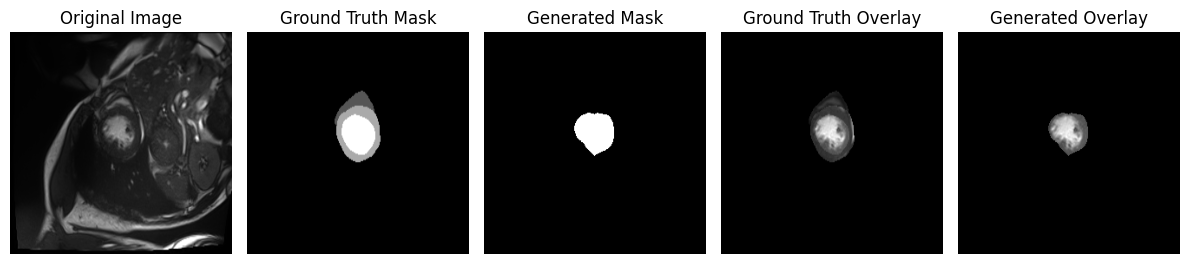

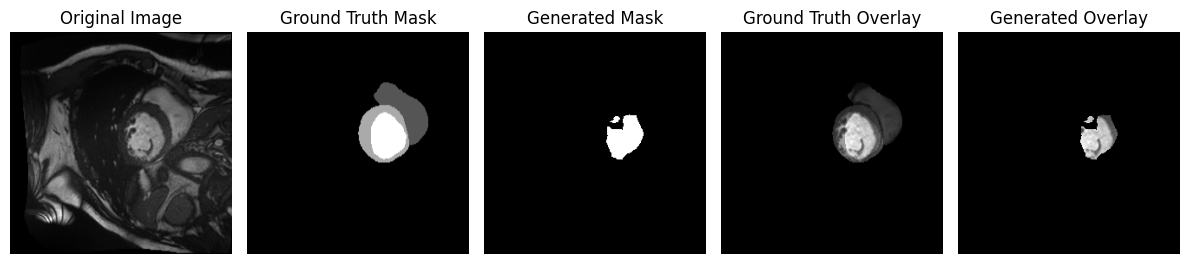

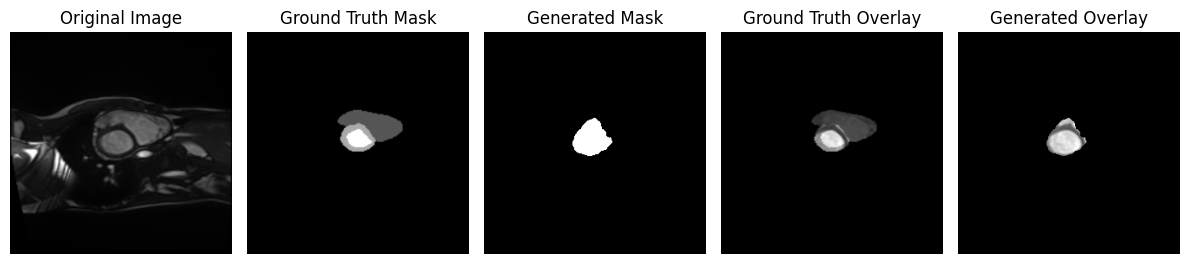

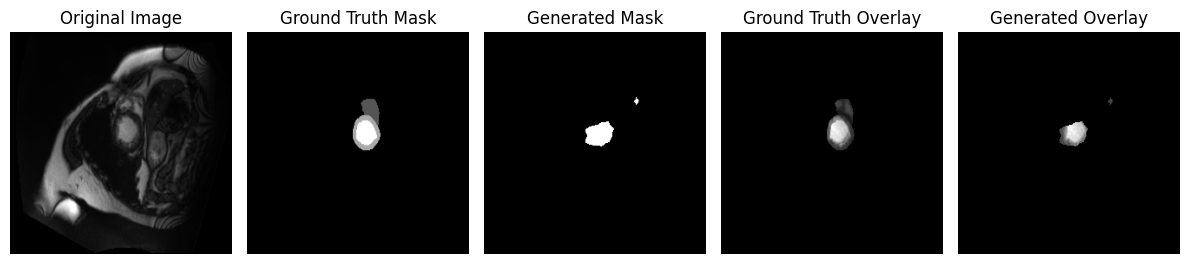

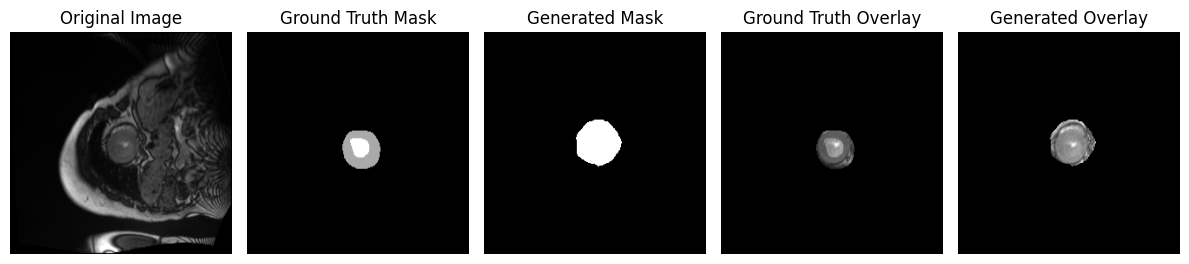

In [77]:
visualize_results(test_images, test_labels, model, num_samples=5)

In [ ]:
# Save the model to a specified file path
model.save("my_model.h5")  # Save as HDF5 file
